#### Causal Workflow: Doubly Robust Estimation

In [6]:
import warnings
import random 
import os
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests

class DataLoader: 

    ZCTA_geo_datapath = '../datasets/State-zip-code-GeoJSON/*.json'
    claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv'
    zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv'
    irs_data_path='../datasets/Demographics/22irs.csv'
    zip_geos_pd='json_to_dfs_no_geom'

    FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
    FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'

    DUCKDB_location = '../datasets/combined_data.db'
    
    def __init__(self): 
        try:
            self.con = self.initialize_ddb()
        except Exception as e: 
            print(e) 
            pass 

    def retrieve_regional_data_snapshot(self, region_str):
        
        assert hasattr(self, 'con') 

        df = self.con.sql(f"select * from zillow_home_prices where Metro ilike '%{region_str}%'").df()
        cols = ['RegionName', 'Metro','CountyName'] + [i for i in df.columns if len(i.split('-')) == 3]
        zillow_df = df[cols]
        zillow_df = zillow_df.rename(
            columns={
                'RegionName':'zip'
            }
        )
        
        zip_codes = zillow_df['zip'].unique()

        zips_str = ','.join(zip_codes)
        irs_df = self.con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
        claims_df = self.con.sql(
            f'''
             select * 
             from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
             inner join zip_geos using (zip)
             order by dateOfLoss
             ;
             '''
        ).df()

        return {
            'ZILLOW' : zillow_df, 
            'IRS_SOCIO': irs_df, 
            'NFIP_CLAIMS': claims_df
        }

    def retrieve_macroeconomic_data(self):

        if hasattr(self, 'macro_data'):
            return self.macro_data 
            
        econ_dataset_codes = {
            'fed_funding_rate':'DFF', 
            '30yr_mortgage_avg':'MORTGAGE30US', 
            '15yr_mortgage_avg':'MORTGAGE15US',  
            'consumer_price_idx':'CPIAUCSL', 
            'real_disposable_income':'DSPIC96', 
            'real_disp_income_per_capita':'A229RX0'
        }

        data=[]
        for col, code in econ_dataset_codes.items(): 
            params = {
                'series_id': code, 'api_key': self.FRED_api_key, 'file_type': 'json'
            }
            try: 
                resp = requests.get(self.FRED_api_endpoint, params=params).json()
                resp_df = pd.DataFrame(resp['observations'])\
                    .drop(columns=['realtime_start','realtime_end'])\
                    .rename(columns={'value':col})
                resp_df[col] = resp_df[col].astype(float)
                resp_df['date'] = pd.to_datetime(resp_df['date'])
                resp_df['year'] = resp_df['date'].dt.year
                resp_df['month'] = resp_df['date'].dt.month 
                resp_df_monthly = resp_df\
                    .drop(columns=['date'])\
                    .groupby(['year','month'])[[col]].mean()
            
                data.append(resp_df_monthly)
            except Exception as e: 
                print(e)
                continue
                        
        cct = pd.concat(data,axis=1)\
            .sort_values(by=['year','month'])\
            .reset_index()
        cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
        cct['date'] = pd.to_datetime(cct['date']) 
        cct = cct.set_index('date')
        self.macro_data = cct
        return cct
        
    def initialize_ddb(self):
        
        if os.path.exists(self.DUCKDB_location): 
            return duckdb.connect(self.DUCKDB_location)
            
        base_query = '''
        drop table if exists nfip_claims
        ;

        create table nfip_claims as 
        select  
            id,
            asOfDate, 
            dateOfLoss,
            policyCount as insuredUnits, 
            baseFloodElevation, 
            ratedFloodZone, 
            occupancyType, 
            originalConstructionDate, 
            originalNBDate, 
            coalesce(amountPaidOnBuildingClaim,0) +                  
            coalesce(amountPaidOnContentsClaim,0) +                  
            coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
            coalesce(totalBuildingInsuranceCoverage,0) + 
            coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
            coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
            buildingDeductibleCode, 
            contentsDeductibleCode,
            causeOfDamage, 
            buildingPropertyValue, 
            floodproofedIndicator, 
            floodEvent, 
            state, 
            reportedZipCode, 
            censusTract, 
            latitude, 
            longitude
        from read_csv('{claims_data_path}', strict_mode=False)
        ;

        drop table if exists nfip_claims_zip 
        ; 

        create table nfip_claims_zip as 
        select 
            reportedZipCode as zip, 
            state,
            floodEvent,
            dateOfLoss,
            count(id) as claimCounts,
            sum(insuredUnits) as policyCounts, 
            sum(totalClaim) as totalClaimZip, 
            sum(totalDamageLoss) as totalLossesZip
        from nfip_claims
        where dateOfLoss >= '2000-01-01'
        group by 1,2,3,4
        order by 5 desc
        ;

        drop table if exists irs_zip
        ;

        create table irs_zip as 
        select 
            STATE, 
            ZIPCODE as zip, 
            AGI_STUB as adjGrossIncomeTaxBracket,
            N1 as numberTaxReturns, 
            MARS1 as singleStatusTotalReturns, 
            MARS2 as marriedStatusTotalReturns, 
            MARS4 as HoHTotalReturns, 
            N2 as totalIndividuals,
            VITA as volunteerAssistedReturns, 
            ELDERLY as elderlyReturns, 
            A00100 as adjustedGrossIncome, 
            A02650 as totalIncome, 
            N00200 as returnsTotalwSalariesWages, 
            N00300 as returnsTotalTaxableInterest, 
            A00300 as taxableInterestAmt,
            SCHF   as returnsTotalFarm, 
            A18450 as stateLocalSalesTaxTotal, 
            N18500 as realEstateTaxTotal, 
            N18800 as returnsTotalPersonalPropertyTax, 
            A18800 as propertyTaxAmtTotal, 
            N19300 as returnsTotalMortgageInterestPaid, 
            A19300 as mortgageInterestPaidTotal,
            N07225 as returnsDependentCareCredit, 
            A07225 as dependentCareCreditTotal, 
            N07230 as returnsEducationCredit, 
            A07230 as educationCreditTotal, 
            N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
            A85770 as premiumsCreditTotal, 
        from read_csv('{irs_data_path}', strict_mode=False)
        ;
    
        drop table if exists zillow_home_prices
        ;

        create table zillow_home_prices as 
        select * 
        from read_csv('{zillow_data_path}', strict_mode=False)
        ;

        drop table if exists zip_geos
        ;

        create table zip_geos as 
        select * 
        from {zip_geos_pd}
        ;
        '''

        read_jsons = [
            gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] 
            for gj in glob.glob(self.ZCTA_geo_datapath)
        ]
        json_to_dfs = pd.concat(read_jsons)
        json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
                }
            )
        json_to_dfs_no_geom = json_to_dfs.drop(columns=['geometry'])
        con = duckdb.connect(self.DUCKDB_location)
        con.sql(
            base_query.format(
                claims_data_path=self.claims_data_path,
                zillow_data_path=self.zillow_data_path, 
                irs_data_path=self.irs_data_path, 
                zip_geos_pd=self.zip_geos_pd
            )
        )
        return con
        
class CausalAnalysis: 
    
    def __init__(self, dataloader, state): 
        
        self.dataloader = dataloader
        self.state = f', {state}'

         #find a better way to do this...prevents db locking from occurring
        if not hasattr(self.dataloader, 'con'):
            self.dataloader.initialize_ddb()
        else: 
            self.dataloader.con = duckdb.connect(self.dataloader.DUCKDB_location)
    
        datasets = self.dataloader.retrieve_regional_data_snapshot(self.state)
        self.dataloader.con.close()
        for n, df in datasets.items():
            print(f'Instantiating dataset {n} into memory')
            setattr(self, n, df)

        self.macroeconomic_indicators = dataloader.retrieve_macroeconomic_data() 

    ### build predictor variable
    def generate_real_estate_shiftindex(self, historical_discount_factor=0.0005):
        
        def weighting_fn(df, alpha):
            df=df.dropna()
            N=len(df)
            w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
            w_norm = w/w.sum() 
            v = 1e3*(df.T@w_norm)
            return v
        
        cpi = self.macroeconomic_indicators\
                  .loc[self.macroeconomic_indicators['year']>=2000][['consumer_price_idx']]\
                  .dropna()\
                  .iloc[1:-1,:]

        cpi['inflation_correction'] = cpi['consumer_price_idx'].iloc[0] / cpi['consumer_price_idx'] 
            
        ts=self.ZILLOW.set_index('zip').drop(columns=['Metro','CountyName']).T
        ts = ts.mul(cpi['inflation_correction'].to_numpy(),axis=0)
        ts_roc = ts.diff().div(ts)
        ts_roc_qtr_smoothed = ts_roc.rolling(4).mean()
        
        return weighting_fn(ts_roc_qtr_smoothed, historical_discount_factor)

    ### build treatment + confounder vars
    def build_features(self):

        socioeconomic_tax_confounders = self.IRS_SOCIO.copy()
        num_rets_feats = [
            'numberTaxReturns',
            'elderlyReturns', 
            'returnsTotalwSalariesWages',
            'returnsDependentCareCredit', 
            'returnsEducationCredit'
        ] 
        piv=socioeconomic_tax_confounders.pivot(
            index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
        )
        piv_norm = piv.div(piv.sum(axis=1),axis=0)
        grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
        grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])

        feature_matrix = pd.concat((piv_norm,grp),axis=1)

        risk_variables = self.NFIP_CLAIMS.copy()
        risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])
        zip_ = \
            risk_variables.groupby(['zip']).agg(
                numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
                totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
                totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
                waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
        )

        zip_['log(totalClaims)'] = np.log(zip_['totalClaims']+0.000001) 
        zip_['log(totalLosses)'] = np.log(zip_['totalLosses']+0.000001) 

        zip_ = zip_.drop(columns=['totalClaims','totalLosses']) 

        rfs = [
            'numberEvents', 
            'waterAreaProp', 
            'log(totalLosses)'
        ]

        rf_matrix = zip_[rfs].values
        rf_matrix_st = StandardScaler().fit_transform(rf_matrix).mean(axis=1)
        zip_['risk_score'] = rf_matrix_st
        zip_['risk_group'] = rf_matrix_st > rf_matrix_st.mean()

        self.FEATURES = pd.concat((feature_matrix, zip_[['risk_group']]),axis=1).dropna()
        
        return self.FEATURES

    def calculate_propensity_scores(self, plot=False): 

        assert hasattr(self, 'FEATURES')
        prop_score_lr = LogisticRegression() 

        X = self.FEATURES.iloc[:,:-1].values
        y = self.FEATURES['risk_group'].astype(bool)

        prop_score_lr.fit(X,y) 
        self.FEATURES['propensity_score'] = prop_score_lr.predict_proba(X)[:,1]

        if plot: 
            self.FEATURES.loc[self.FEATURES['risk_group']]['propensity_score'].hist(alpha=0.5,label='risky',bins=25)
            self.FEATURES.loc[self.FEATURES['risk_group']==False]['propensity_score'].hist(alpha=0.5,label='non-risky',bins=25)
            plt.title('Propensity Score Distributions')
            plt.legend()
            plt.show()

        return prop_score_lr, self.FEATURES

    def build_matching_groups(self):

        self.calculate_propensity_scores() 

        #idk find a better way to do this, use a mathematical optimization approach? find lit. on this
        COVERED = set()
        def search_closest_match(output_idx_lst, df=self.FEATURES):
            for i in output_idx_lst[1:]:
        
                r = df.iloc[i]
                zip = r.name
        
                if r['risk_group']:
                    if zip in COVERED:
                        continue 
                    else:
                        COVERED.add(zip)
                        return zip

        dataset_match = self.FEATURES.loc[self.FEATURES['risk_group']==False][['propensity_score']]
        prop_score = self.FEATURES['propensity_score'].to_numpy().reshape(-1,1)

        nn = NearestNeighbors(n_neighbors=5, radius=0.25) 
        nn.fit(prop_score)

        control = dataset_match['propensity_score'].to_numpy().reshape(-1,1)
        _, nearest_i = nn.kneighbors(control)

        zip_matched = [
            search_closest_match(i) for i in nearest_i
        ]
        dataset_match['matched_zip_risky'] = zip_matched

        dataset_match = \
        dataset_match\
            .reset_index()\
            .drop(columns=['propensity_score'])\
            .rename(
                columns={
                    'zip':'matched_zip_nonrisky'
                }
        )

        dataset_match = dataset_match.dropna()
   
        return dataset_match

    def build_treatment_effect_report(self, discount_factor, plot=False):
        
        self.matched_zips = self.build_matching_groups() 
        self.home_pr_indices = self.generate_real_estate_shiftindex(
            historical_discount_factor=discount_factor
        )
        
        def search_index(zip, s=self.home_pr_indices):
            return s.loc[zip]
        
        self.matched_zips['idx_nonrisky'] = self.matched_zips['matched_zip_nonrisky'].apply(search_index)
        self.matched_zips['idx_risky'] = self.matched_zips['matched_zip_risky'].apply(search_index)
        self.matched_zips['idx_diff'] = self.matched_zips['idx_risky']-self.matched_zips['idx_nonrisky']
        if plot: 
            self.matched_zips['idx_nonrisky'].hist(bins=50, alpha=0.5, label='Non-risky Price Shift Index')
            self.matched_zips['idx_risky'].hist(bins=50, alpha=0.5, label='Risky Price Shift Index')
            plt.title('Price Shifts by Zip-code Groups')
            plt.legend()
            plt.show()
            
        test_sig = ranksums(self.matched_zips['idx_nonrisky'],self.matched_zips['idx_risky'])
        
        diffs = self.matched_zips['idx_diff']
        bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
        obs = self.matched_zips['idx_diff'].mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist.quantile(0.025), 
            bootstrapped_sample_dist.quantile(0.975)
        ]
        self.report = {
            'State': self.state, 
            'Discount Factor': discount_factor,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'p-value': test_sig.pvalue, 
            'Significant?': bool(test_sig.pvalue < 0.05 and obs < 0)
        }

        if plot: 
            plt.hist(bootstrapped_sample_dist, bins=50,)
            plt.title('ATE Estimation')

            plt.axvline(self.matched_zips['idx_diff'].mean(), label=f"Observed ATE: {self.matched_zips['idx_diff'].mean()}",color='red')
            plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
            plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
            plt.legend()
            plt.show()
        
        return self.matched_zips, self.report


In [7]:
dl = DataLoader() 
analysis = CausalAnalysis(
    dataloader = dl, 
    state = 'FL'
)

feature_matrix = analysis.build_features() 
housing_price_shift_idx = analysis.generate_real_estate_shiftindex() 
housing_price_shift_idx.name = 'price_shift'

feature_matrix.head(10)

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory


,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit,risk_group
zip,,,,,,,,,,,
32003,0.203488,0.162064,0.132994,0.112645,0.267442,0.121366,0.340843,0.768895,0.273256,0.047965,True
32008,0.322314,0.268595,0.157025,0.099174,0.128099,0.024793,0.314050,0.780992,0.235537,0.037190,False
32009,0.213836,0.220126,0.144654,0.144654,0.238994,0.037736,0.283019,0.830189,0.289308,0.031447,False
32011,0.232310,0.240320,0.157543,0.116155,0.212283,0.041389,0.257677,0.839786,0.295060,0.038718,False
32024,0.295378,0.266065,0.158963,0.099211,0.146561,0.033822,0.299887,0.793687,0.262683,0.040586,False
32025,0.336696,0.298865,0.153846,0.083228,0.108449,0.018916,0.268600,0.804540,0.259773,0.039092,False
32033,0.256198,0.227273,0.169421,0.123967,0.169421,0.053719,0.442149,0.677686,0.202479,0.020661,False
32034,0.202153,0.163313,0.122602,0.097801,0.240524,0.173608,0.493215,0.654188,0.167057,0.022929,True
32038,0.323009,0.280973,0.152655,0.097345,0.123894,0.022124,0.318584,0.776549,0.232301,0.035398,False


In [8]:
housing_price_shift_idx.head(10)

zip
34787    0.211878
34953   -0.024085
33024    1.650506
33411    0.747349
33025   -0.031039
33311    1.741316
33023    2.812417
33012    3.844847
33015    3.361115
33186    3.937166
Name: price_shift, dtype: float64

#### build workflow: doubly robust estimation 

consider the following components: 
* propensity score model (treatment assignment prob. per zip)
* price shift prediction (outcome modeling)
* ATE estimation conditional on (1) and (2). Assumes at least one of the following are "correct"


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

prop_model, feature_matrix_w_pscore = analysis.calculate_propensity_scores()
ttl_dataset = pd.concat((feature_matrix_w_pscore, housing_price_shift_idx),axis=1).dropna()

outcome_model = RandomForestRegressor(n_estimators=150) 
#outcome_model_params = {
 #   'n_estimators' : np.arange(10, 210, 10), 
  #  'max_depth': np.arange(1,11), 
#}
#outcome_model_cv = GridSearchCV(
 #   outcome_model, 
  #  outcome_model_params
#)

X, y = ttl_dataset.iloc[:, :-2].values, ttl_dataset['price_shift']
outcome_model.fit(X,y) 

X_pred_nonrisk = X.copy() 
X_pred_nonrisk[:,-1] = False 
y_0 = outcome_model.predict(X_pred_nonrisk)

X_pred_risk = X.copy() 
X_pred_risk[:,-1] = True
y_1 = outcome_model.predict(X_pred_nonrisk)

ttl_dataset['y_0'] = y_0 
ttl_dataset['y_1'] = y_1 + ((ttl_dataset['price_shift']-y_1)/ttl_dataset['propensity_score'])
ttl_dataset['treatment_effect'] = ttl_dataset['y_1']-ttl_dataset['y_0']
ttl_dataset.head(10)


,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit,risk_group,propensity_score,price_shift,y_0,y_1,treatment_effect
zip,,,,,,,,,,,,,,,,
32003,0.203488,0.162064,0.132994,0.112645,0.267442,0.121366,0.340843,0.768895,0.273256,0.047965,True,0.388246,0.103879,-0.269329,0.691937,0.961267
32008,0.322314,0.268595,0.157025,0.099174,0.128099,0.024793,0.314050,0.780992,0.235537,0.037190,False,0.364690,5.128550,3.843757,7.366734,3.522977
32009,0.213836,0.220126,0.144654,0.144654,0.238994,0.037736,0.283019,0.830189,0.289308,0.031447,False,0.300455,2.228421,1.686864,3.489318,1.802454
32011,0.232310,0.240320,0.157543,0.116155,0.212283,0.041389,0.257677,0.839786,0.295060,0.038718,False,0.292266,3.447911,2.331089,6.152341,3.821251
32024,0.295378,0.266065,0.158963,0.099211,0.146561,0.033822,0.299887,0.793687,0.262683,0.040586,False,0.338458,3.136075,1.745044,5.854958,4.109914
32025,0.336696,0.298865,0.153846,0.083228,0.108449,0.018916,0.268600,0.804540,0.259773,0.039092,False,0.326008,1.481266,1.070855,2.329756,1.258902
32033,0.256198,0.227273,0.169421,0.123967,0.169421,0.053719,0.442149,0.677686,0.202479,0.020661,False,0.467191,-3.432416,-2.897227,-4.042773,-1.145546
32034,0.202153,0.163313,0.122602,0.097801,0.240524,0.173608,0.493215,0.654188,0.167057,0.022929,True,0.582957,0.164179,-0.890228,0.918494,1.808722
32038,0.323009,0.280973,0.152655,0.097345,0.123894,0.022124,0.318584,0.776549,0.232301,0.035398,False,0.367851,5.109830,4.145281,6.767402,2.622121


In [10]:
ttl_dataset['treatment_effect'].mean()

np.float64(-0.47664974911520647)

#### build off of the existing class 

In [11]:
#!pip install econml

class DoubleRobustLearning(CausalAnalysis): 
    
    def build_matching_groups(self): 
        raise NotImplementedError() 

    def run_DRL(self, outcome_model, discount_factor):
        
        self.discount_factor = discount_factor
        self.calculate_propensity_scores() 
        
        home_pr_indices = self.generate_real_estate_shiftindex(
            historical_discount_factor=discount_factor
        )
        home_pr_indices.name = 'price_shift'
        
        feature_matrix = self.FEATURES.copy() 
        ttl_dataset = pd.concat((feature_matrix, home_pr_indices),axis=1).dropna()
        
        X, y = ttl_dataset.iloc[:, :-2].values, ttl_dataset['price_shift']
        outcome_model.fit(X,y) 

        X_pred_nonrisk = X.copy() 
        X_pred_nonrisk[:,-1] = False 
        y_0 = outcome_model.predict(X_pred_nonrisk)

        X_pred_risk = X.copy() 
        X_pred_risk[:,-1] = True
        y_1 = outcome_model.predict(X_pred_nonrisk)

        ttl_dataset['y_0'] = y_0 
        ttl_dataset['y_1'] = y_1 + ((ttl_dataset['price_shift']-y_1)/ttl_dataset['propensity_score'])
        ttl_dataset['treatment_effect'] = ttl_dataset['y_1']-ttl_dataset['y_0']

        self.DRL_result = ttl_dataset
        return ttl_dataset

    def build_treatment_effect_report(self, plot=False): 
        
        assert hasattr(self, 'DRL_result')
        
        diffs = self.DRL_result['treatment_effect']
        
        bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
        obs = diffs.mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist.quantile(0.025), 
            bootstrapped_sample_dist.quantile(0.975)
        ]
        self.report = {
            'State': self.state, 
            'Discount Factor': self.discount_factor,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'Significant?': bootstrapped_sample_dist.max() < 0 
        }

        if plot: 
            plt.hist(bootstrapped_sample_dist, bins=50,)
            plt.title('ATE Estimation')

            plt.axvline(diffs.mean(), label=f"Observed ATE: {diffs.mean()}",color='red')
            plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
            plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
            plt.legend()
            plt.show()
        
        return self.DRL_result, self.report


In [12]:
from sklearn.ensemble import RandomForestRegressor
coastal_states = [
    'FL','GA', 'LA', 'NC', 'SC', 'TX'
]
dfacs = np.arange(0,1.0,0.05)
res = []
for dfac in dfacs:
    for state in coastal_states:
        causal_analysis = DoubleRobustLearning(dl, state=state)
        causal_analysis.build_features()

        outcome_model = RandomForestRegressor(n_estimators=150) 

        causal_analysis.run_DRL(
            outcome_model = outcome_model, 
            discount_factor = dfac
        )
        _, re = causal_analysis.build_treatment_effect_report( 
            plot=False
        ) 
        
        res.append(re)
        

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , FL: -0.47216784403075773
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , GA: 0.04257651486548477
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , LA: -0.026411919266928197
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , NC: 0.006063427217603241
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
A

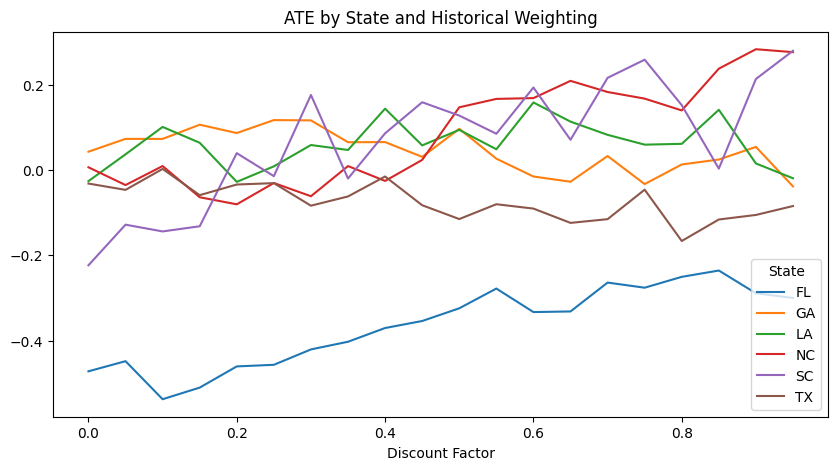

In [13]:
data=pd.DataFrame(res)
data['State'] = data['State'].str.replace(', ', '')
data.pivot(index='Discount Factor', values='ATE Estimate', columns='State').plot(title='ATE by State and Historical Weighting', figsize=(10,5))
plt.show()

In [14]:
data.loc[data['Discount Factor'] == 0.05]

,State,Discount Factor,ATE Estimate,ATE Confidence Bounds (95 pct),Significant?
6,FL,0.05,-0.448424,"[-0.6542982670391168, -0.25001785309198143]",True
7,GA,0.05,0.072629,"[-0.11545211562286911, 0.26370178293388663]",False
8,LA,0.05,0.036459,"[-0.345523490358088, 0.4274615201421921]",False
9,NC,0.05,-0.035623,"[-0.2239090721569215, 0.14909626468487855]",False
10,SC,0.05,-0.128466,"[-0.47776888501872006, 0.22896207203830418]",False
11,TX,0.05,-0.046896,"[-0.20446341531856121, 0.10473976205633129]",False


Text(0.5, 1.0, 'Climate Impact Treatment Effect Estimates: Doubly Robust Learning')

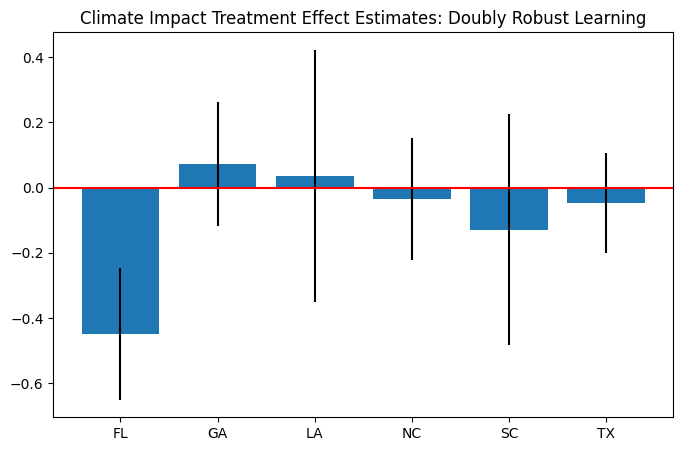

In [15]:
plt.rcParams['figure.figsize']=(8,5)
states = [
    'FL','GA', 'LA', 'NC', 'SC', 'TX'
]

data_t = data.loc[data['State'].isin(states)]
data_t['err'] = data_t['ATE Confidence Bounds (95 pct)'].apply(lambda x: (x[1]-x[0])/2)
data_t = data_t.loc[data_t['Discount Factor'] == 0.05]
plt.bar(
    data_t['State'], 
    data_t['ATE Estimate'], 
    yerr=data_t['err'],
)
plt.axhline(0,color='red')
plt.title('Climate Impact Treatment Effect Estimates: Doubly Robust Learning')


In [16]:
coastal_states = ['TX', 'LA', 'FL', 'GA', 'SC', 'NC']
dfacs = np.arange(0,1.0,0.05)
res = []
for dfac in dfacs:
    for state in coastal_states:
        causal_analysis = CausalAnalysis(dl, state=state)
        causal_analysis.build_features()
        _, re = causal_analysis.build_treatment_effect_report(
            discount_factor=dfac, 
            plot=False
        ) 
        res.append(re)

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , TX: -0.3466352769510457
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , LA: -0.06677017964921499
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , FL: -1.2827405331183055
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices , GA: -0.04819922775466733
Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Ave

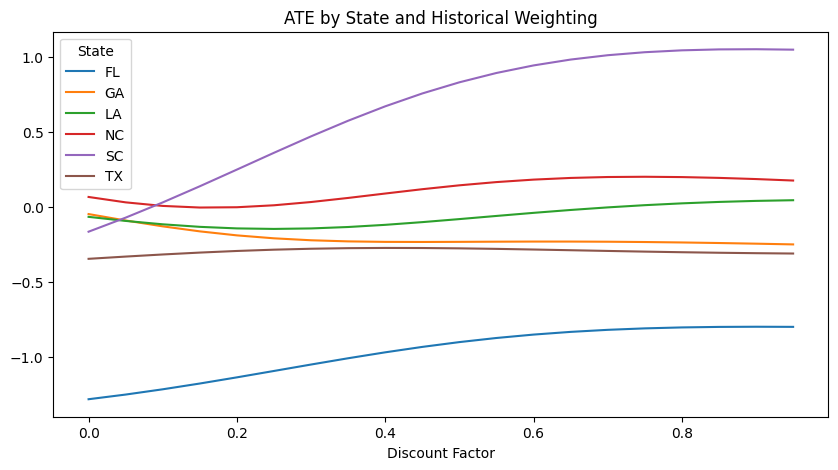

In [17]:
data=pd.DataFrame(res)
data['State'] = data['State'].str.replace(', ', '')
data.pivot(index='Discount Factor', values='ATE Estimate', columns='State').plot(title='ATE by State and Historical Weighting', figsize=(10,5))
plt.show()

Text(0.5, 1.0, 'Climate Impact Treatment Effect Estimates: Propensity Score Matching')

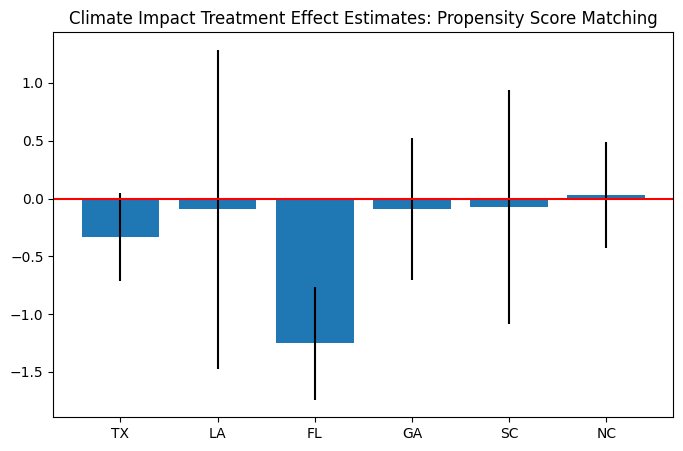

In [18]:
states = [
    'FL','GA', 'LA', 'NC', 'SC', 'TX'
]

data_t = data.loc[data['State'].isin(states)]
data_t['err'] = data_t['ATE Confidence Bounds (95 pct)'].apply(lambda x: (x[1]-x[0])/2)
data_t = data_t.loc[data_t['Discount Factor'] == 0.05]
plt.bar(
    data_t['State'], 
    data_t['ATE Estimate'], 
    yerr=data_t['err'],
)
plt.axhline(0,color='red')
plt.title('Climate Impact Treatment Effect Estimates: Propensity Score Matching')

In [1]:
dl.close()

NameError: name 'dl' is not defined

notes, chernozhukov et. al. (debiased machine learning), add this to a new nb 

* instead of fixing a binary outcome for each treatment assignment, consider using a "propensity score"-like quantity instead as our treatment variable?
* the coefficient corresponding to the reduced treatment variable is the treatment effect we want to estimate
* assumes that the number of confounding features are very high
* treatment model must be regularized to avoid a high variance fit (i.e. overfitting)
* ^^^^assumes a naive construction
* consider modeling the residual of the treatment model with the ground truth policy (i.e. orthogonalization) to reduce bias


